In [1]:
import pickle

import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import sklearn
from sklearn import linear_model
import torch

from cvae.cvae import ConditionalVAE
from envs.panda_center_out import PandaCenterOutEnv

In [2]:
with open('data/demonstration_center_out.pkl', 'rb') as fp:
    episodes = pickle.load(fp)

In [3]:
env = PandaCenterOutEnv(render=False, control_type='ee')

# Enumerate the goals

goals = set()

while len(goals) != 8:
    obs = env.reset()
    goals.add(tuple(obs['desired_goal']))
    
goals = sorted(list(goals), key=lambda g: (-g[1], g[0]))

neutral_ee_position = obs['achieved_goal']
neutral_joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])

# Enumerate the joint angles for each goal

joint_angles_at_goals = []

for goal in goals:
    while tuple(env._get_obs()['desired_goal']) != goal:
        obs = env.reset()
    
    is_success = False
    while not is_success:
        a = obs['desired_goal'] - obs['achieved_goal']
        obs, _, _, info = env.step(a)
        is_success = info['is_success']
        
    joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])
    joint_angles_at_goals.append(joint_angles)

In [4]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi])

In [5]:
env = PandaCenterOutEnv(render=False, control_type='joints')

## whole-elevator-412
KL = 1 annealed

Here, posterior collapse happens and we can observe the decoder at 9 different positions depend solely on context.

In [6]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/9lz2c49j/checkpoints/epoch=399-step=1000399.ckpt')

In [7]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

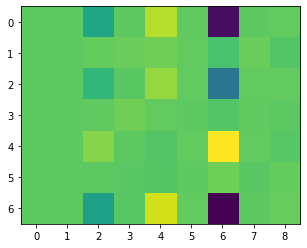

In [8]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())

In [9]:
next(decoder.decoder.parameters()).detach().numpy()

array([[ 4.4364211e-04,  9.3678193e-04, -4.5799952e+00, -7.5995423e-02,
         3.8853855e+00,  2.3626091e-02, -2.0227585e+01, -7.1434185e-02,
         2.0566139e-01],
       [-2.0562501e-03,  4.5506092e-04,  2.9889315e-01,  5.2153254e-01,
         8.1875581e-01,  1.9729017e-01, -1.1072595e+00,  5.0126910e-01,
        -5.5182427e-01],
       [-2.8146512e-04,  6.7975605e-04, -2.6193705e+00, -2.4980301e-01,
         2.5035496e+00,  2.0775352e-01, -1.0185790e+01,  1.3349937e-01,
         1.3763426e-01],
       [-2.9036263e-03,  2.4326156e-04,  2.4885610e-02,  9.0295863e-01,
         2.3452958e-01,  1.9427292e-02, -6.2419486e-01,  1.3296147e-01,
        -1.5223478e-01],
       [ 1.9720364e-04, -2.7013043e-04,  1.8022285e+00, -1.9538173e-01,
        -6.2991858e-01,  1.9361794e-01,  6.9926457e+00,  1.9166657e-01,
        -3.2290369e-01],
       [ 1.1292141e-03, -3.5796355e-04, -1.1612303e-01, -2.9343012e-01,
        -4.6862087e-01, -8.6031377e-02,  7.8090477e-01, -1.9941765e-01,
         2.

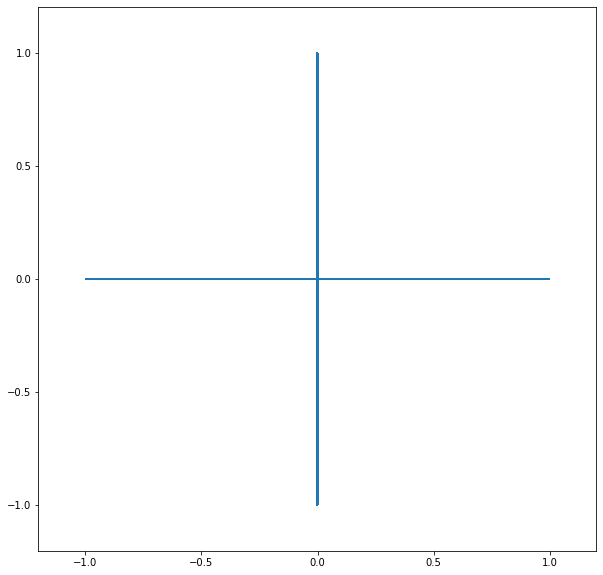

In [10]:
actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi])
actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

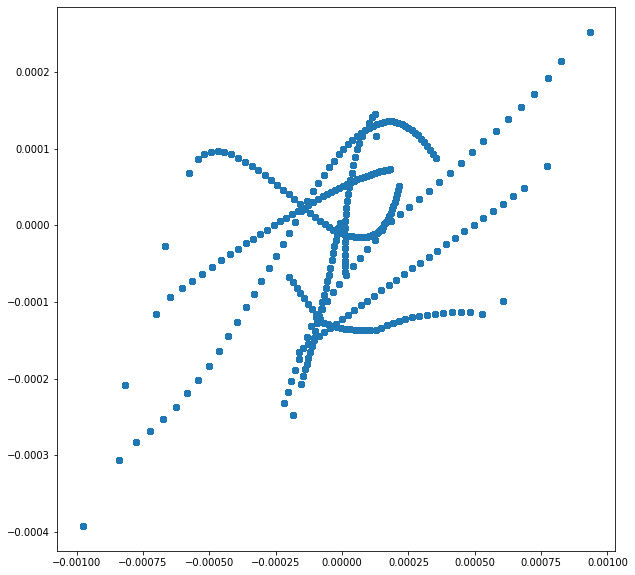

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

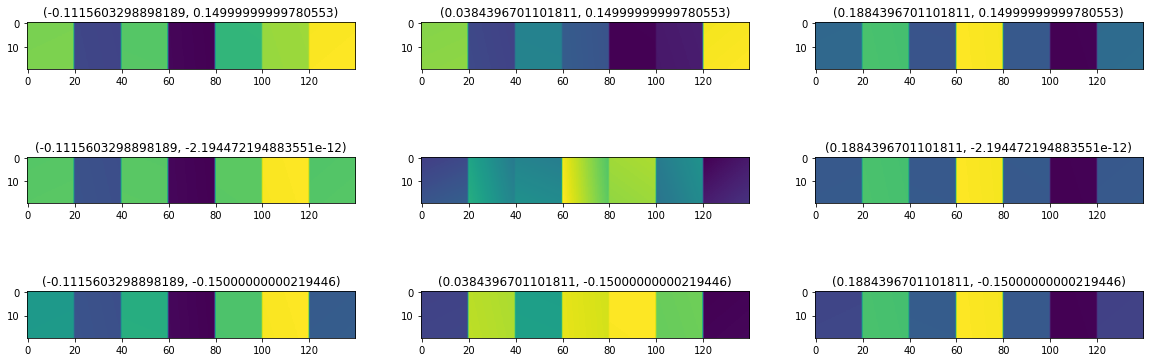

In [12]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)

fig, axs = plt.subplots(3, 3, figsize=(20, 7))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    axs[i // 3, i % 3].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
    axs[i // 3, i % 3].set_title(goal[:2])
    
contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
axs[1, 1].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))

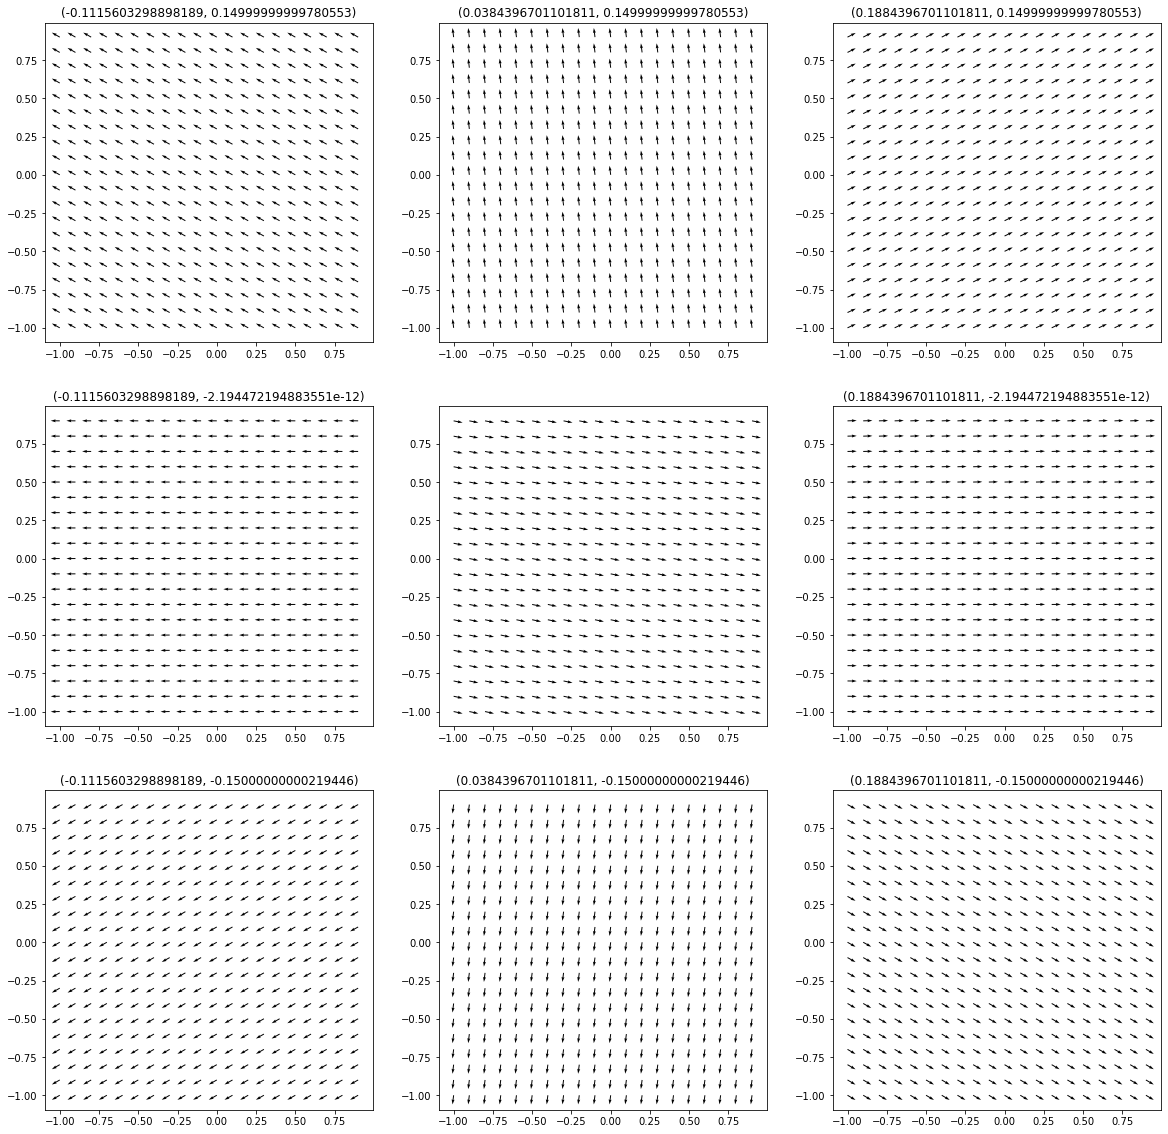

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization
    
    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    
    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

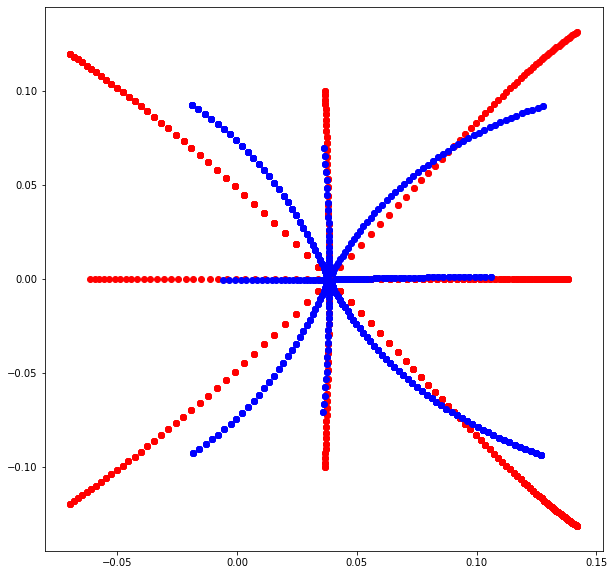

In [14]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    
    ee_positions_predicted = []
    for step in episode:
        z = decoder.encoder(
            torch.cat((
                torch.tensor(step['action_joints'], dtype=torch.float), 
                torch.tensor(step['previous_joint_angles'], dtype=torch.float)))).reshape(1, -1)
        z = decoder.fc_mu(z)
        joint_action = decoder(
            latent=z, 
            context=torch.tensor(step['previous_joint_angles'][np.newaxis, :], dtype=torch.float))
        obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()

## efficient-frog-413
KL = 0

Here, the surprising result is that instead of using context, the decoder mostly rely on latents to do reconstruction. This may suggest the context is not strong enough.

In [15]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/ayxhfutb/checkpoints/epoch=399-step=1000399.ckpt')

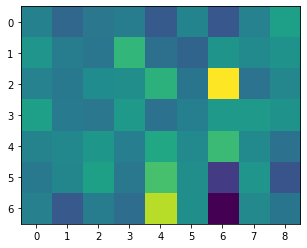

In [16]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())

In [17]:
next(decoder.decoder.parameters()).detach().numpy()

array([[-0.01811444, -0.28743488, -0.12266625, -0.05214556, -0.40103528,
         0.00793373, -0.42991132, -0.00286679,  0.29546696],
       [ 0.1892652 , -0.05342431, -0.13190413,  0.5375793 , -0.18754362,
        -0.30711174,  0.17549942,  0.06957973,  0.17113267],
       [-0.00616788, -0.10113484,  0.10314108,  0.11843015,  0.48087478,
        -0.14279789,  1.3686182 , -0.16037965,  0.04096023],
       [ 0.29250148, -0.08249994, -0.12507889,  0.22586353, -0.1683247 ,
        -0.03760411,  0.22962177,  0.22648928,  0.17105623],
       [ 0.00308023,  0.05225122,  0.20869581, -0.04903711,  0.36824825,
         0.06665618,  0.581397  ,  0.08325853, -0.1821261 ],
       [-0.1026611 ,  0.02941217,  0.30354378, -0.11075008,  0.65045494,
         0.12097634, -0.6718686 ,  0.18379392, -0.46299624],
       [-0.02623837, -0.41280836, -0.0683402 , -0.21849516,  1.1054868 ,
         0.12908281, -1.1033493 ,  0.0603245 , -0.13833563]],
      dtype=float32)

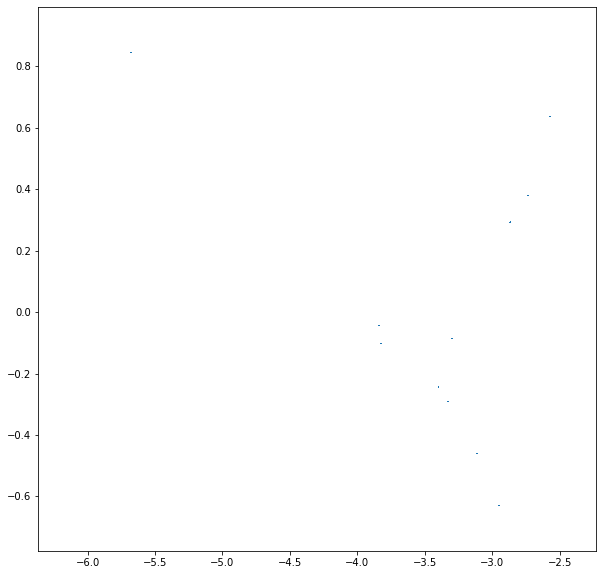

In [18]:
actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi])
actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

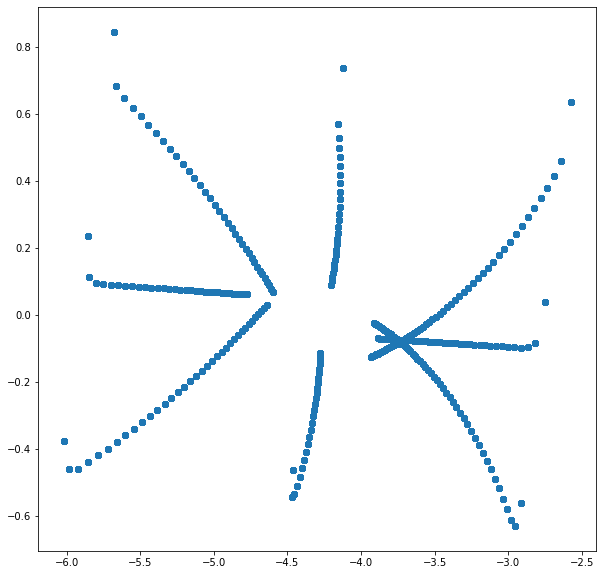

In [19]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

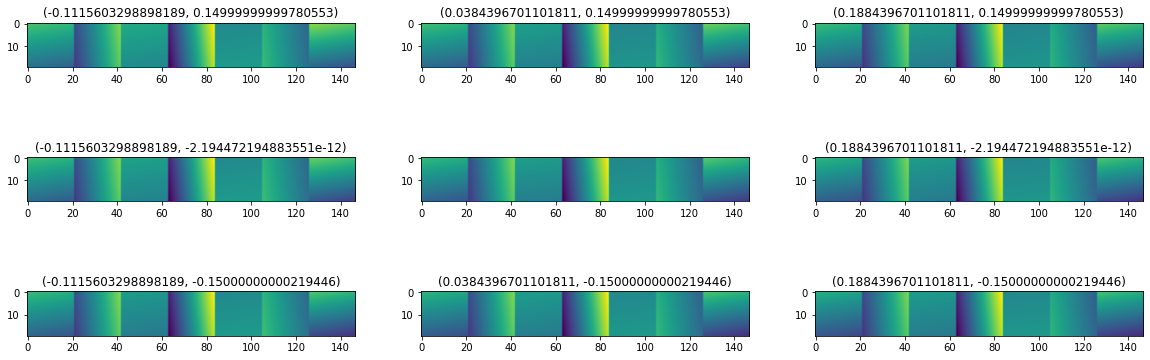

In [20]:
x, y = np.meshgrid(np.arange(-6, -2.5, 0.17), np.arange(-0.6, 0.8, 0.07))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)

fig, axs = plt.subplots(3, 3, figsize=(20, 7))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    axs[i // 3, i % 3].imshow(np.concatenate([actions_joints[:, i].reshape(20, 21) for i in range(7)], axis=1))
    axs[i // 3, i % 3].set_title(goal[:2])
    
contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
axs[1, 1].imshow(np.concatenate([actions_joints[:, i].reshape(20, 21) for i in range(7)], axis=1))

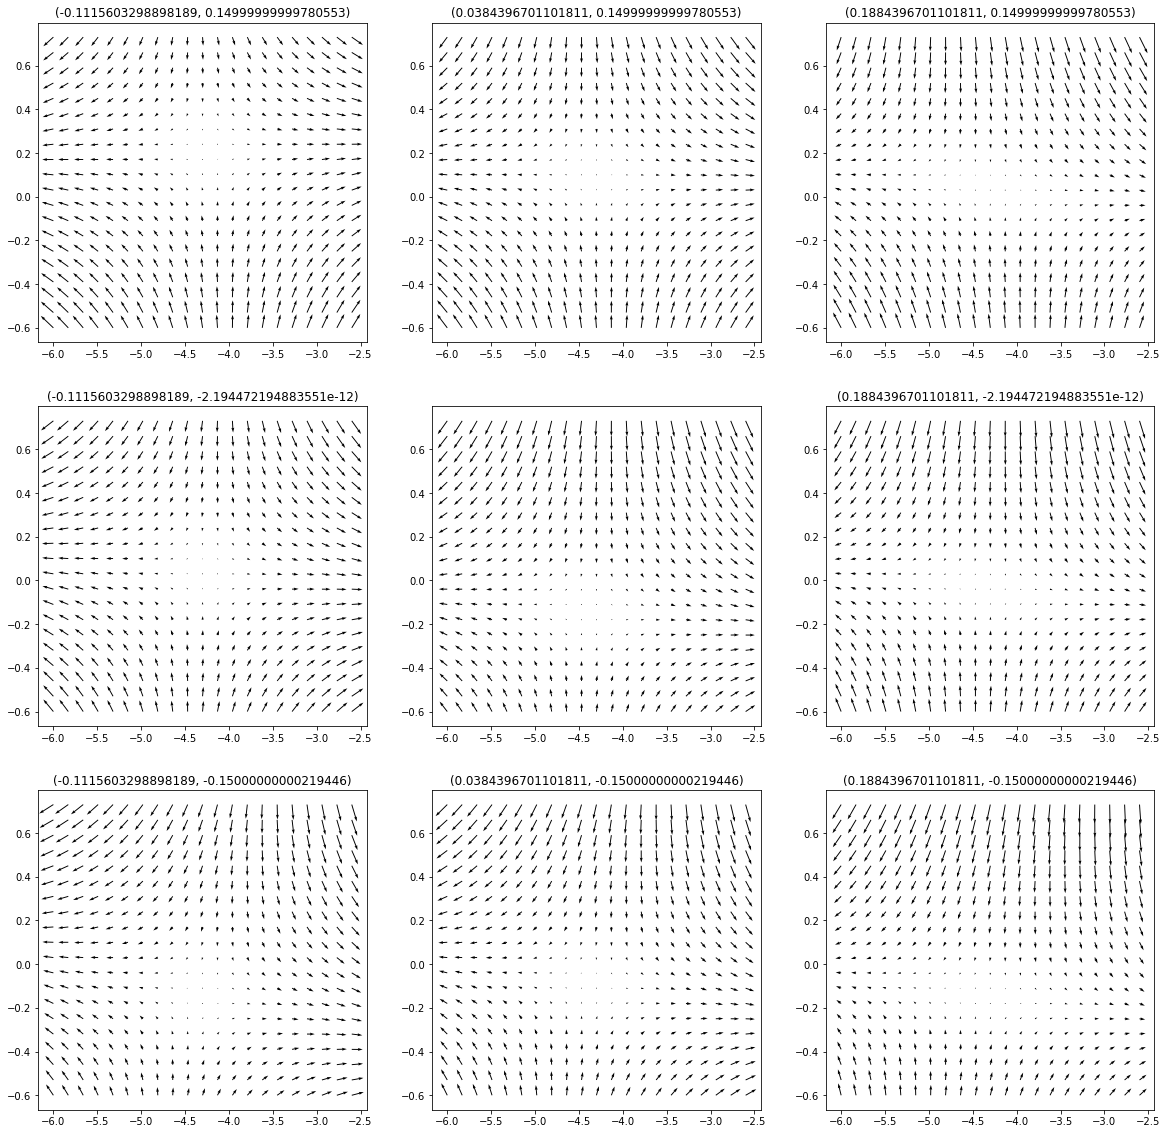

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization
    
    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    
    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

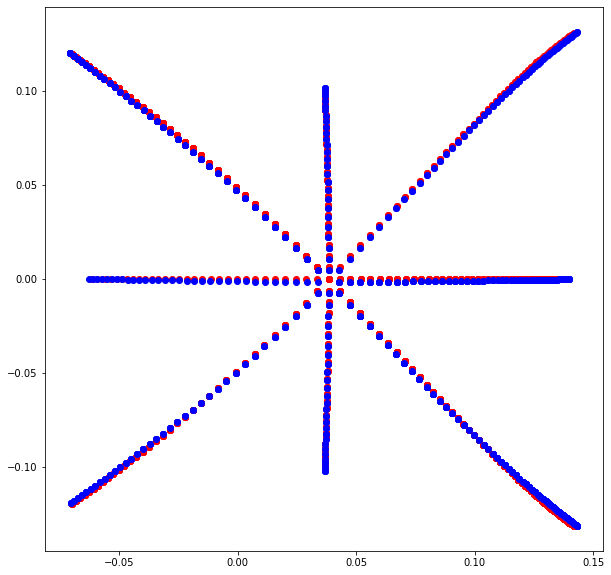

In [22]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    
    ee_positions_predicted = []
    for step in episode:
        z = decoder.encoder(
            torch.cat((
                torch.tensor(step['action_joints'], dtype=torch.float), 
                torch.tensor(step['previous_joint_angles'], dtype=torch.float)))).reshape(1, -1)
        z = decoder.fc_mu(z)
        joint_action = decoder(
            latent=z, 
            context=torch.tensor(step['previous_joint_angles'][np.newaxis, :], dtype=torch.float))
        obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()

## galiant-grass-415
The latents were zeroed out during training. This should essentially be supervised training with (context, action).

Important question: is the context alone sufficient to decode the action? The qualitative behavior is identical to a posterior collapsed VAE.

In [23]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/26m873lh/checkpoints/epoch=399-step=1000399.ckpt')

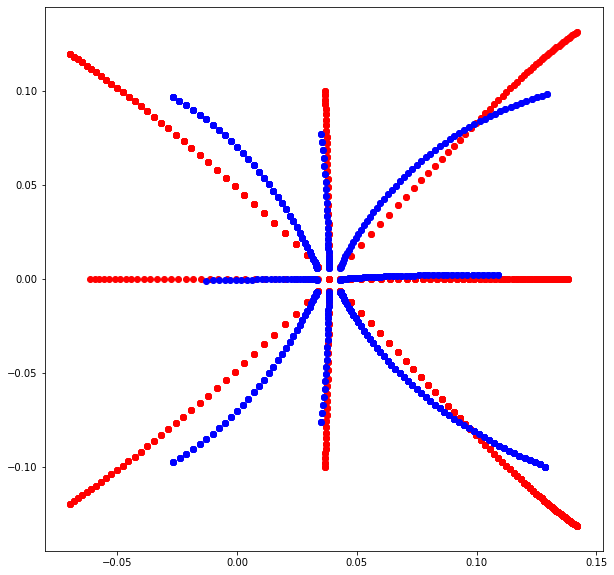

In [24]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    env.robot.set_joint_angles(episode[1]['previous_joint_angles'])
    
    ee_positions_predicted = []
    for step in episode:
        joint_action = decoder(
            latent=torch.zeros(1, 2), 
            context=torch.tensor(step['previous_joint_angles'][np.newaxis, :], dtype=torch.float))
        obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()

## Linear Regression

Just in case something is wrong with the zeroing out latent idea...

In [25]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi])
previous_joint_angles = np.array([step['previous_joint_angles'] for epi in episodes for step in epi])

In [26]:
decoder = linear_model.LinearRegression()

In [27]:
decoder.fit(previous_joint_angles, actions_joints)

LinearRegression()

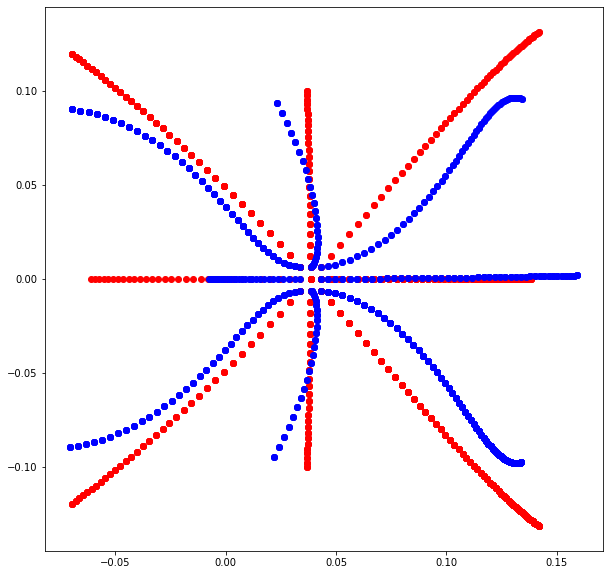

In [28]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    env.robot.set_joint_angles(episode[1]['previous_joint_angles'])
    
    ee_positions_predicted = []
    for step in episode:
        joint_action = decoder.predict(step['previous_joint_angles'][np.newaxis, :])
        obs, _, _, _ = env.step(joint_action.squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()

## valiant-haze-417
KL = 0

Would adding depth allow the decoder make better use of the context and start to ignore the latent?

In [29]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/30x6kxj4/checkpoints/epoch=399-step=1000399.ckpt')

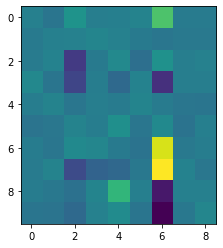

In [30]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())

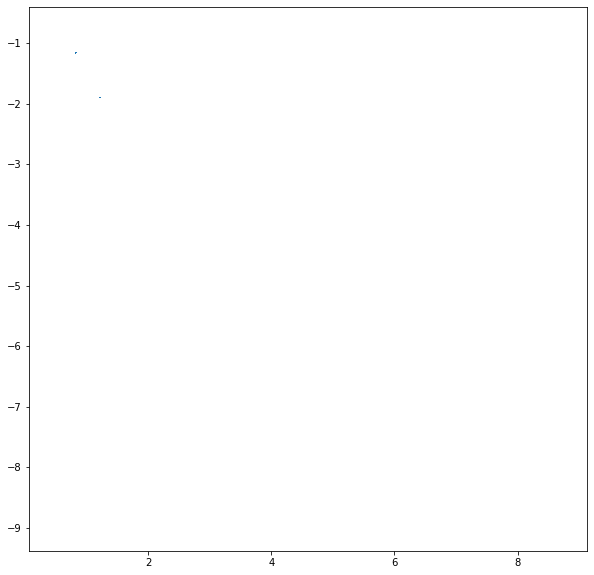

In [31]:
actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi])
actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

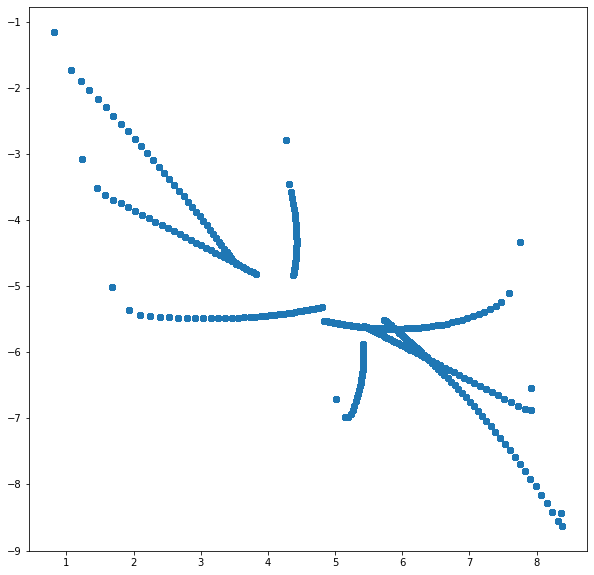

In [32]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

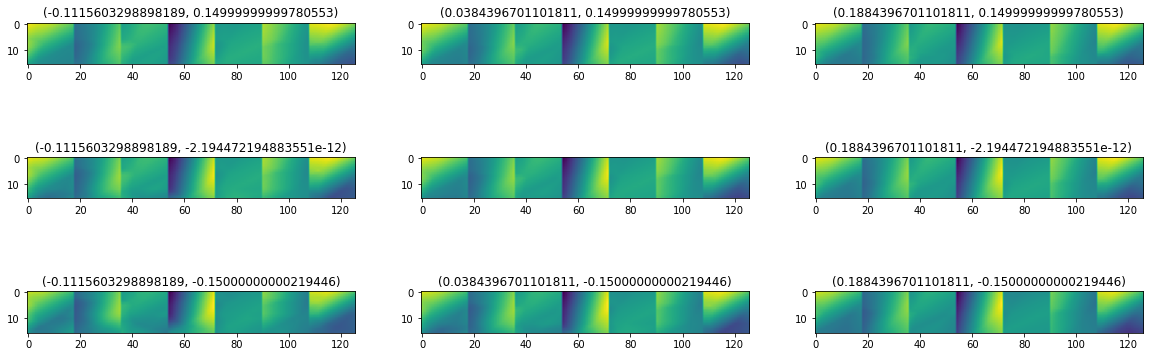

In [33]:
x, y = np.meshgrid(np.arange(0, 9, 0.5), np.arange(-9, -1, 0.5))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)

fig, axs = plt.subplots(3, 3, figsize=(20, 7))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    axs[i // 3, i % 3].imshow(np.concatenate([actions_joints[:, i].reshape(16, 18) for i in range(7)], axis=1))
    axs[i // 3, i % 3].set_title(goal[:2])
    
contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
axs[1, 1].imshow(np.concatenate([actions_joints[:, i].reshape(16, 18) for i in range(7)], axis=1))

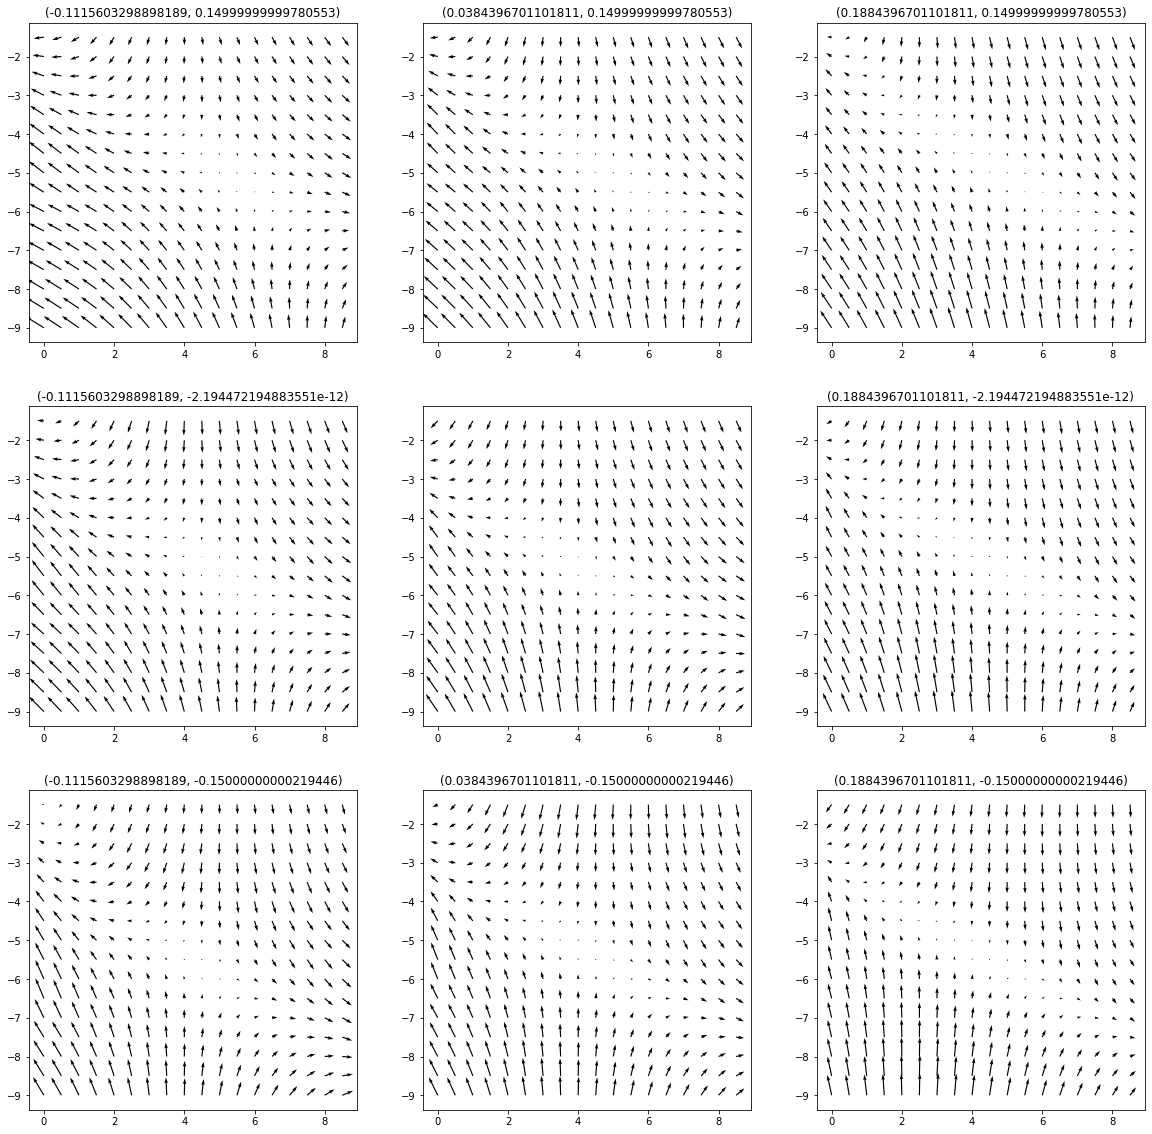

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization
    
    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    
    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

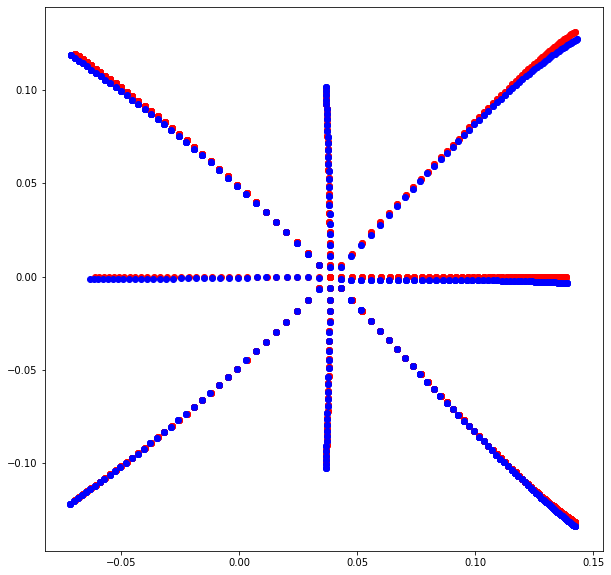

In [35]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    
    ee_positions_predicted = []
    for step in episode:
        z = decoder.encoder(
            torch.cat((
                torch.tensor(step['action_joints'], dtype=torch.float), 
                torch.tensor(step['previous_joint_angles'], dtype=torch.float)))).reshape(1, -1)
        z = decoder.fc_mu(z)
        joint_action = decoder(
            latent=z, 
            context=torch.tensor(step['previous_joint_angles'][np.newaxis, :], dtype=torch.float))
        obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()

Why does the decoder field look the same at all 9 positions?

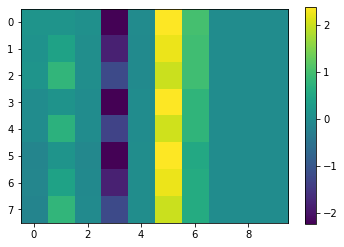

In [36]:
plt.imshow(joint_angles_at_goals)
plt.colorbar()

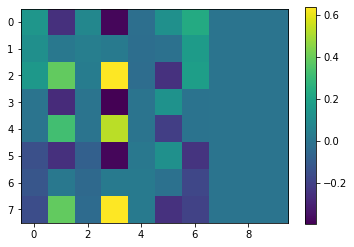

In [37]:
plt.imshow(joint_angles_at_goals - neutral_joint_angles)
plt.colorbar()

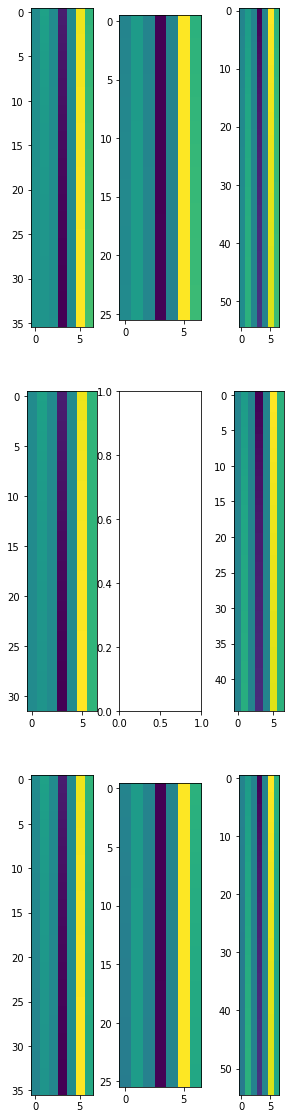

In [38]:
# How much does the joint angles context change in each episode?

fig, axs = plt.subplots(3, 3, figsize=(5, 20))

for i, goal in enumerate(goals):
    if i >= 4:
        i += 1 # offset for visualization
        
    for j, episode in enumerate(episodes):
        if np.all(episode[0]['previous_observation']['desired_goal'] == goal):
            break

    axs[i // 3, i % 3].imshow(np.stack([step['previous_joint_angles'] for step in episode]))

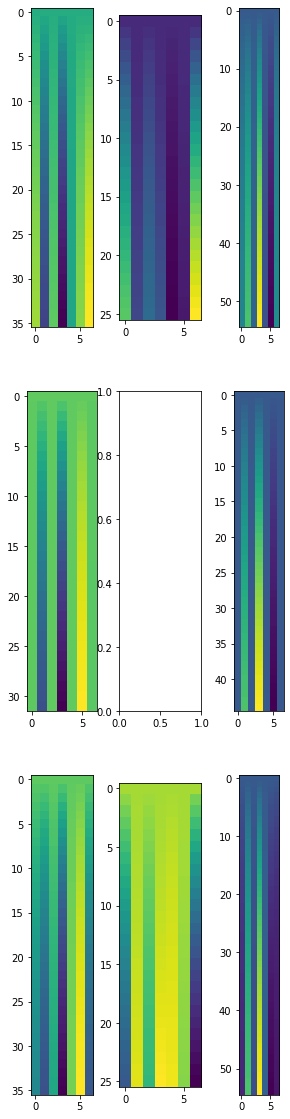

In [39]:
# Subtract the neutral joint angles and the change is more obvious

fig, axs = plt.subplots(3, 3, figsize=(5, 20))

for i, goal in enumerate(goals):
    if i >= 4:
        i += 1 # offset for visualization
        
    for j, episode in enumerate(episodes):
        if np.all(episode[0]['previous_observation']['desired_goal'] == goal):
            break
    
    axs[i // 3, i % 3].imshow(np.stack([step['previous_joint_angles'] - neutral_joint_angles[:7] for step in episode]))

## polar-aardvark-414

KL = 0.0001

If we slightly regularize the latent space, would the decoder show context dependence?

In [40]:
decoder = ConditionalVAE.load_from_checkpoint('latent-action/i45a8pmk/checkpoints/epoch=399-step=1000399.ckpt')

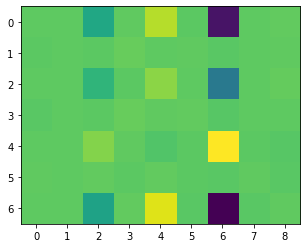

In [41]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())

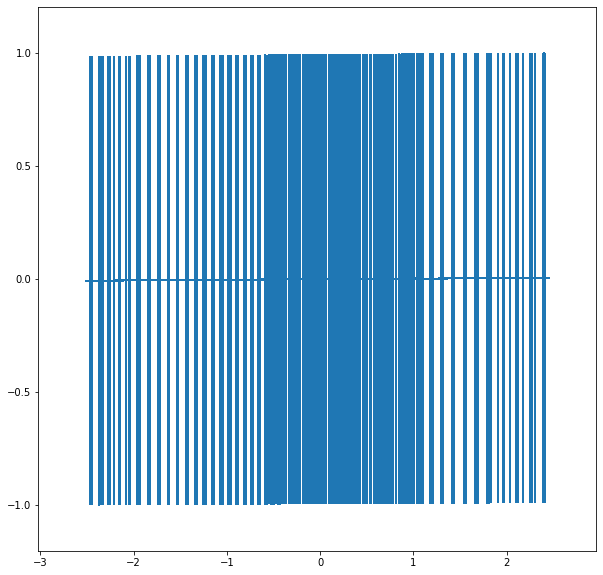

In [42]:
actions_joints_test = np.array([(step['action_joints'], step['previous_joint_angles']) for epi in episodes for step in epi])
actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

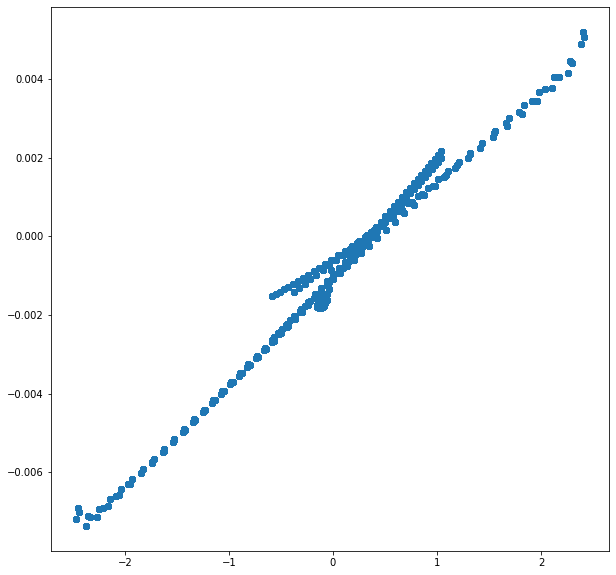

In [43]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

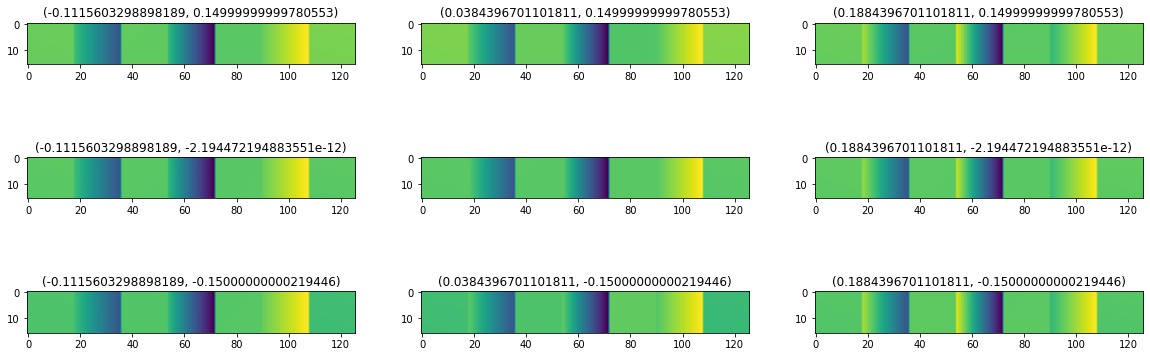

In [44]:
x, y = np.meshgrid(np.arange(0, 9, 0.5), np.arange(-9, -1, 0.5))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)

fig, axs = plt.subplots(3, 3, figsize=(20, 7))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    axs[i // 3, i % 3].imshow(np.concatenate([actions_joints[:, i].reshape(16, 18) for i in range(7)], axis=1))
    axs[i // 3, i % 3].set_title(goal[:2])
    
contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
axs[1, 1].imshow(np.concatenate([actions_joints[:, i].reshape(16, 18) for i in range(7)], axis=1))

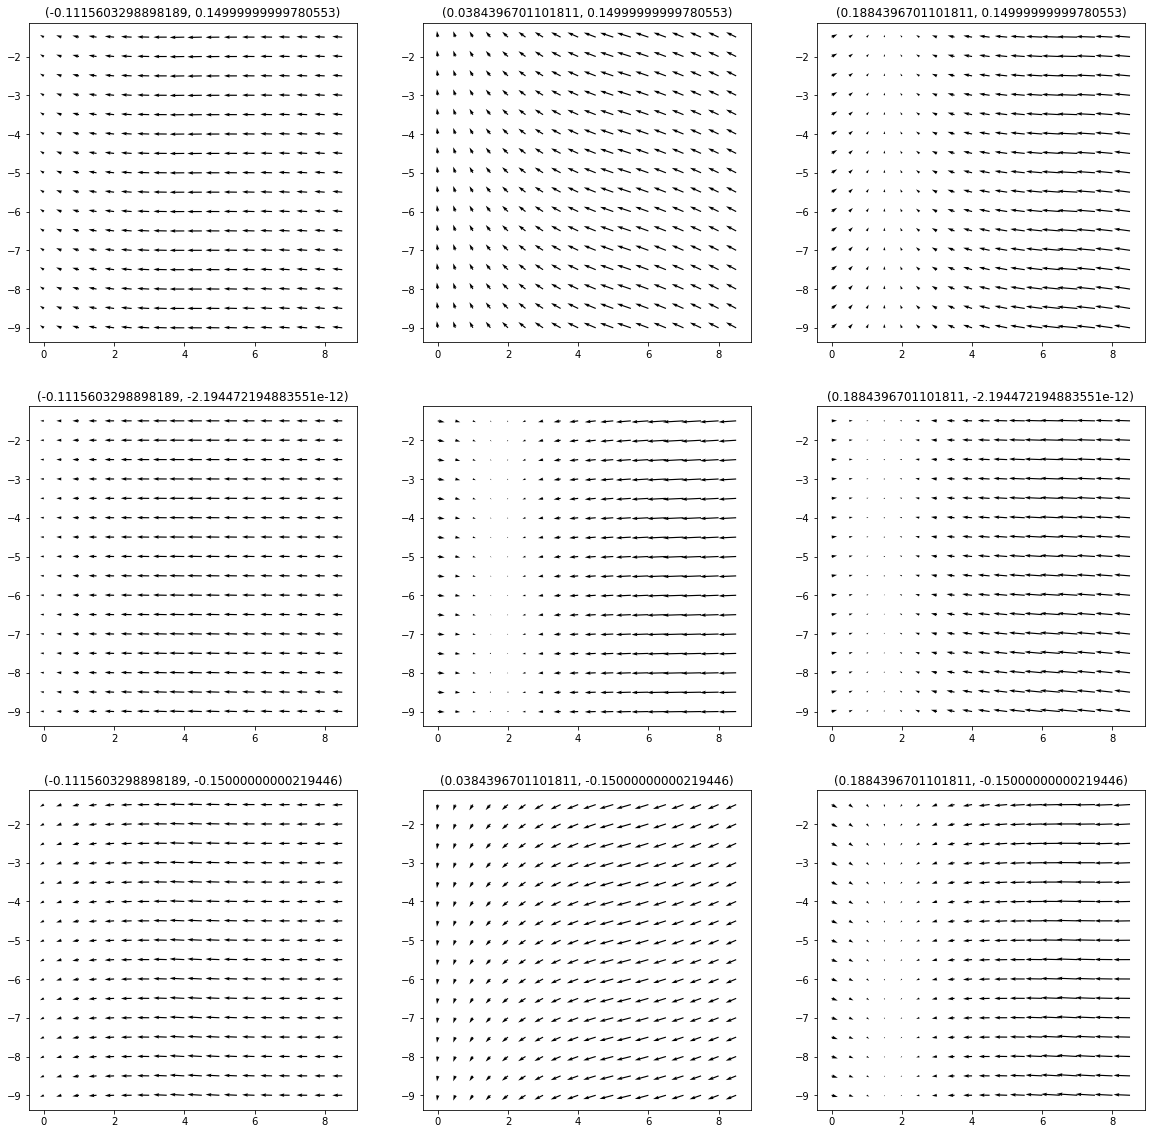

In [45]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization
    
    contexts = torch.tensor(np.stack([joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
    actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
    
    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

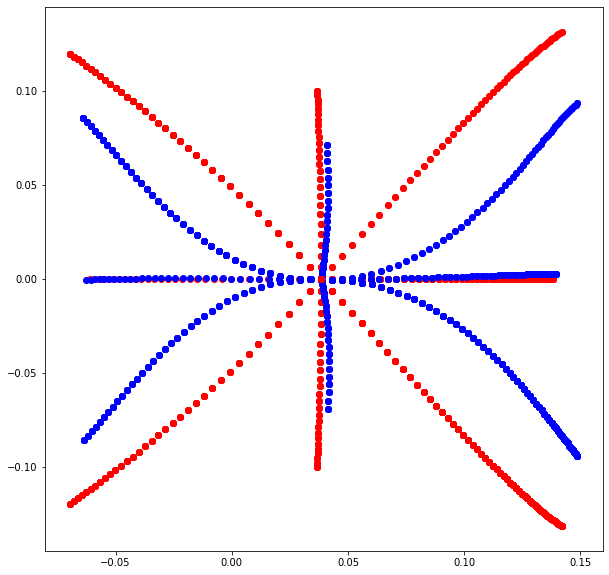

In [46]:
# Offline evaluation

fig = plt.figure(figsize=(10, 10))

for episode in episodes[:30]:
    ee_positions_ground_truth = np.array(
        [step['previous_observation']['achieved_goal'] for step in episode])
    plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')
    
    obs = env.reset()
    
    ee_positions_predicted = []
    for step in episode:
        z = decoder.encoder(
            torch.cat((
                torch.tensor(step['action_joints'], dtype=torch.float), 
                torch.tensor(step['previous_joint_angles'], dtype=torch.float)))).reshape(1, -1)
        z = decoder.fc_mu(z)
        joint_action = decoder(
            latent=z, 
            context=torch.tensor(step['previous_joint_angles'][np.newaxis, :], dtype=torch.float))
        obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
        ee_positions_predicted.append(obs['achieved_goal'])
        
    ee_positions_predicted = np.array(ee_positions_predicted)
    plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')
    
plt.show()